# Style Transfer

__Load the libraries__

In [12]:
import torch 
from torchvision import transforms , models 
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

__Next, we need to choose which device to run the network on and import the content and style images. Running the neural transfer algorithm on large images takes longer and will go much faster when running on a GPU. We can use torch.cuda.is_available() to detect if there is a GPU available. Next, we set the torch.device for use throughout the tutorial. Also the .to(device) method is used to move tensors or modules to a desired device__

In [13]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

__assign pre-trained model vgg19 or vgg16, 
here we are using a 19 layer VGG network vgg19__

In [14]:
model = models.vgg19(pretrained=True).features
for p in model.parameters():
    p.requires_grad = False
model.to(device)  

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

__Load content and style images and transform them to device__

In [15]:
transform = transforms.Compose([transforms.Resize(300),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])


content = Image.open("content3.jpg").convert("RGB")
content = transform(content).to(device)
print("Content shape => ", content.shape)
style = Image.open("style2.jpg").convert("RGB")
style = transform(style).to(device)

Content shape =>  torch.Size([3, 300, 450])


__Convert the image into numpy array and plot the images__

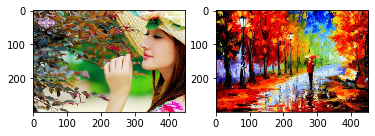

In [16]:
def imcnvt(image):
    x = image.to("cpu").clone().detach().numpy().squeeze()
    x = x.transpose(1,2,0)
    x = x*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    return x

fig, (ax1,ax2) = plt.subplots(1,2)

ax1.imshow(imcnvt(content),label = "Content")
ax2.imshow(imcnvt(style),label = "Style")
plt.show()

__In order to calculate the style loss, we need to compute the gram matrix GXL. A gram matrix is the result of multiplying a given matrix by its transposed matrix.__
__And we use copy of the content image as target__

In [17]:
def gram_matrix(imgfeature):
    _,d,h,w = imgfeature.size()
    imgfeature = imgfeature.view(d,h*w)
    gram_mat = torch.mm(imgfeature,imgfeature.t())
    
    return gram_mat


target = content.clone().requires_grad_(True).to(device)


print("device = ",device)

device =  cpu


__We need model activation function with layers of convolutional neural network defined as dictionay to segment each image features into layers__

In [18]:
def model_activations(input,model):
    layers = {
    '0' : 'conv1_1',
    '5' : 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'
    }
    features = {}
    x = input
    x = x.unsqueeze(0)
    for name,layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x 
    
    return features

style_features = model_activations(style,model)
content_features = model_activations(content,model)

style_wt_meas = {"conv1_1" : 1.0, 
                 "conv2_1" : 0.8,
                 "conv3_1" : 0.4,
                 "conv4_1" : 0.2,
                 "conv5_1" : 0.1}

style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}


__import optimizer from torch and set number of epochs and style weight, content weight and then calculate amount of style loss and content loss in each epoch and optimize the value to the output image__

epoch  10   tensor(1.9073e+13, grad_fn=<AddBackward0>)
epoch  20   tensor(1.1247e+13, grad_fn=<AddBackward0>)
epoch  30   tensor(7.1535e+12, grad_fn=<AddBackward0>)
epoch  40   tensor(5.0754e+12, grad_fn=<AddBackward0>)
epoch  50   tensor(3.6239e+12, grad_fn=<AddBackward0>)
epoch  60   tensor(2.6335e+12, grad_fn=<AddBackward0>)
epoch  70   tensor(2.0201e+12, grad_fn=<AddBackward0>)
epoch  80   tensor(1.6206e+12, grad_fn=<AddBackward0>)
epoch  90   tensor(1.3421e+12, grad_fn=<AddBackward0>)
epoch  100   tensor(1.1268e+12, grad_fn=<AddBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


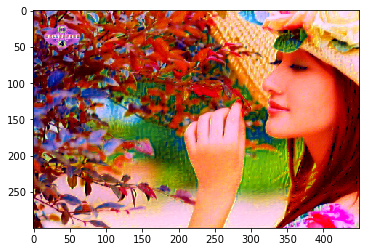

epoch  110   tensor(9.4648e+11, grad_fn=<AddBackward0>)
epoch  120   tensor(7.9257e+11, grad_fn=<AddBackward0>)
epoch  130   tensor(6.6286e+11, grad_fn=<AddBackward0>)
epoch  140   tensor(5.5658e+11, grad_fn=<AddBackward0>)
epoch  150   tensor(4.7207e+11, grad_fn=<AddBackward0>)
epoch  160   tensor(4.0648e+11, grad_fn=<AddBackward0>)
epoch  170   tensor(3.5611e+11, grad_fn=<AddBackward0>)
epoch  180   tensor(3.1708e+11, grad_fn=<AddBackward0>)
epoch  190   tensor(2.8615e+11, grad_fn=<AddBackward0>)
epoch  200   tensor(2.6097e+11, grad_fn=<AddBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


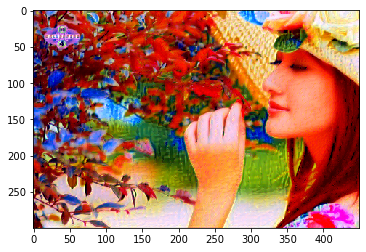

epoch  210   tensor(2.3993e+11, grad_fn=<AddBackward0>)
epoch  220   tensor(2.2194e+11, grad_fn=<AddBackward0>)
epoch  230   tensor(2.0627e+11, grad_fn=<AddBackward0>)
epoch  240   tensor(1.9242e+11, grad_fn=<AddBackward0>)
epoch  250   tensor(1.8001e+11, grad_fn=<AddBackward0>)
epoch  260   tensor(1.6879e+11, grad_fn=<AddBackward0>)
epoch  270   tensor(1.5858e+11, grad_fn=<AddBackward0>)
epoch  280   tensor(1.4923e+11, grad_fn=<AddBackward0>)
epoch  290   tensor(1.4063e+11, grad_fn=<AddBackward0>)
epoch  300   tensor(1.3270e+11, grad_fn=<AddBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


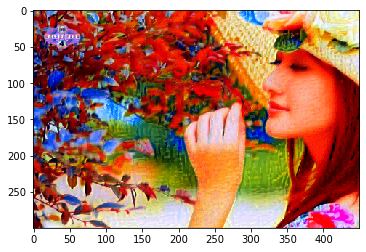

epoch  310   tensor(1.2537e+11, grad_fn=<AddBackward0>)
epoch  320   tensor(1.1857e+11, grad_fn=<AddBackward0>)
epoch  330   tensor(1.1228e+11, grad_fn=<AddBackward0>)
epoch  340   tensor(1.0642e+11, grad_fn=<AddBackward0>)
epoch  350   tensor(1.0098e+11, grad_fn=<AddBackward0>)
epoch  360   tensor(9.5912e+10, grad_fn=<AddBackward0>)
epoch  370   tensor(9.1185e+10, grad_fn=<AddBackward0>)
epoch  380   tensor(8.6774e+10, grad_fn=<AddBackward0>)
epoch  390   tensor(8.2651e+10, grad_fn=<AddBackward0>)
epoch  400   tensor(7.8790e+10, grad_fn=<AddBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


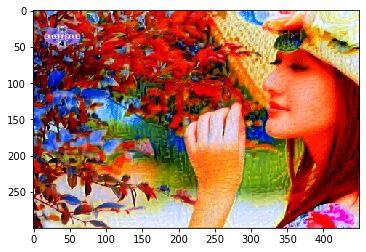

epoch  410   tensor(7.5173e+10, grad_fn=<AddBackward0>)
epoch  420   tensor(7.1785e+10, grad_fn=<AddBackward0>)
epoch  430   tensor(6.8608e+10, grad_fn=<AddBackward0>)
epoch  440   tensor(6.5624e+10, grad_fn=<AddBackward0>)
epoch  450   tensor(6.2820e+10, grad_fn=<AddBackward0>)
epoch  460   tensor(6.0180e+10, grad_fn=<AddBackward0>)
epoch  470   tensor(5.7694e+10, grad_fn=<AddBackward0>)
epoch  480   tensor(5.5351e+10, grad_fn=<AddBackward0>)
epoch  490   tensor(5.3141e+10, grad_fn=<AddBackward0>)
epoch  500   tensor(5.1053e+10, grad_fn=<AddBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


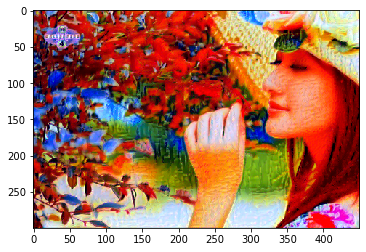

In [19]:
content_wt = 100
style_wt = 100

print_after = 100
epochs = 500
optimizer = torch.optim.Adam([target],lr=0.007)

for i in range(1,epochs+1):
    target_features = model_activations(target,model)
    content_loss = torch.mean((content_features['conv4_2']-target_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_wt_meas:
        style_gram = style_grams[layer]
        target_gram = target_features[layer]
        _,d,w,h = target_gram.shape
        target_gram = gram_matrix(target_gram)

        style_loss += (style_wt_meas[layer]*torch.mean((target_gram-style_gram)**2))/d*w*h
    
    total_loss = content_wt*content_loss + style_wt*style_loss 
    
    if i%10==0:       
        print("epoch ",i," ", total_loss)
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i%print_after == 0:
        plt.imshow(imcnvt(target),label="Epoch "+str(i))
        plt.show()

__And if you wish to save the output image then normalise it and use imsave pre-defined function of pytorch as follows__
_put this block in continuation after plt.show_

In [ ]:
img_array = imcnvt(target)
img_array = (img_array-np.min(img_array))/(np.max(img_array)-np.min(img_array))
plt.imsave(str(i)+'.png',img_array,format = 'PNG')